Linear (ridge) regression to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

Use CV for more reliable NSE estimates

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate

np.random.seed(0)

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings()

Test: 2010-01-09 00:00:00 - 2010-12-31
Skipping 04214500
Median NSE: 0.08296560547741805	MSE: 63.05159544096098
Test: 2011-01-01 - 2011-12-31
Skipping 04214500
Median NSE: 0.257474611371181	MSE: 192.62364258185636
Test: 2012-01-01 - 2012-12-31
Median NSE: -0.389947724281148	MSE: 67.06191126357018
Test: 2013-01-01 - 2013-12-31
Median NSE: 0.32266439744235054	MSE: 142.22717526828347
Test: 2014-01-01 - 2014-12-31
Median NSE: 0.24079676785824283	MSE: 109.70695921767023


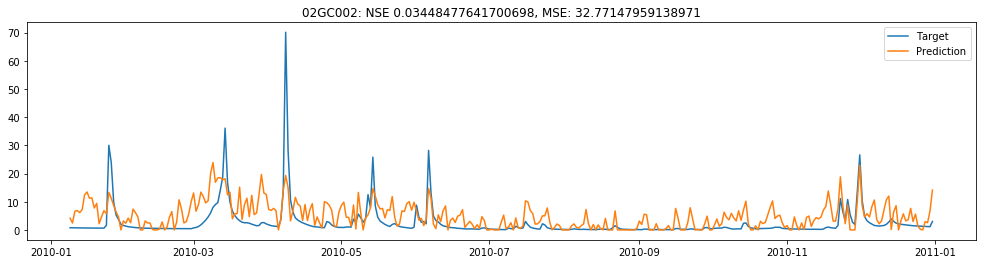

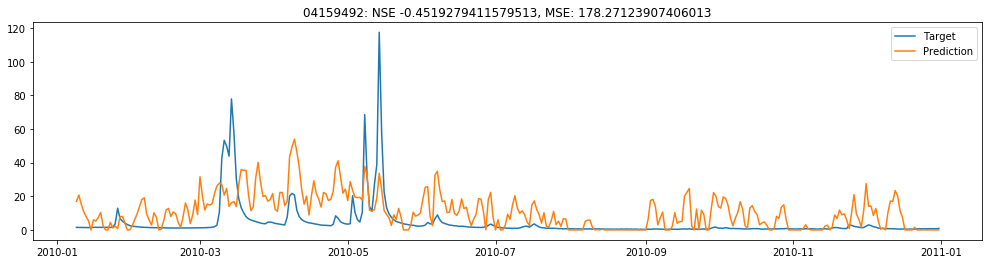

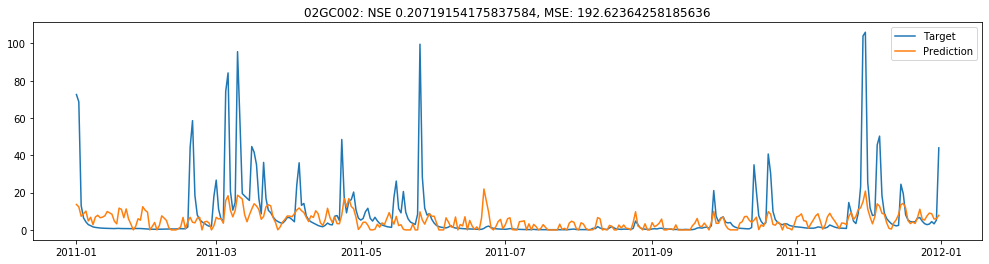

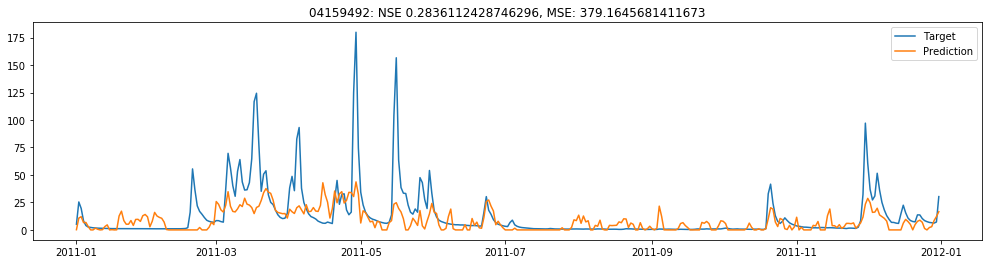

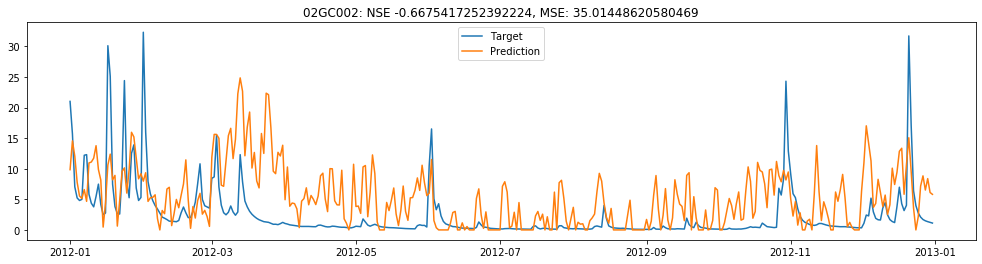

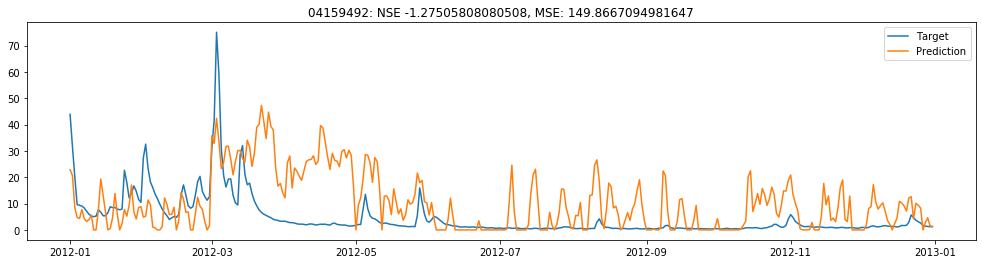

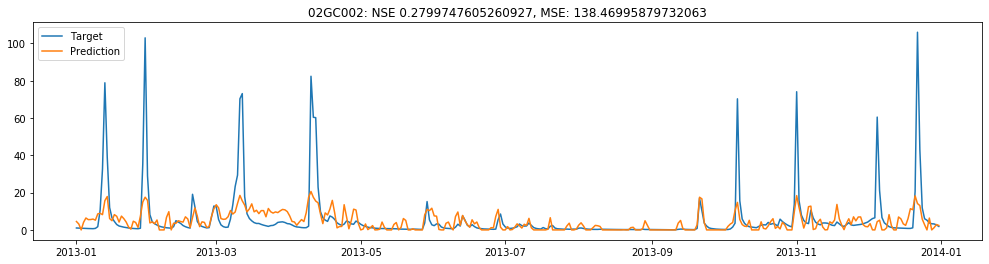

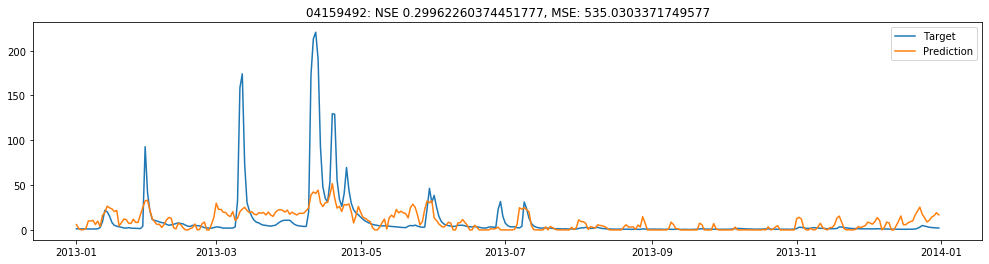

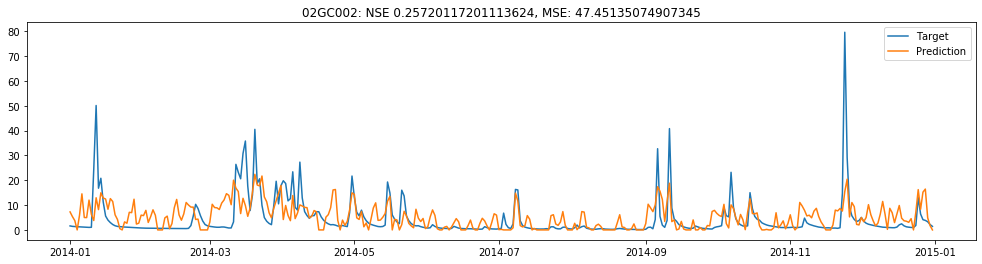

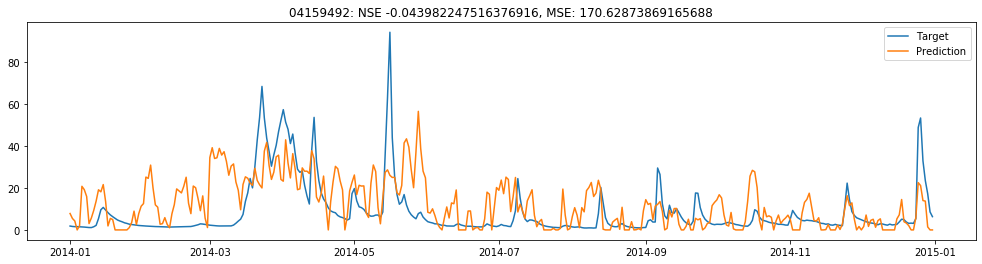

In [6]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
data_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
test_starts = [data_start, '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01']
test_ends = ['2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31']

plot_list = ['04159492', '02GC002']
median_nse_mse_list = []
for cv_iter in range(len(test_starts)):
    test_start, test_end = test_starts[cv_iter], test_ends[cv_iter]
    print('Test: {} - {}'.format(test_start, test_end))
    
    predictions = {}
    actuals = {}
    models = {}
    nse_list, mse_list = [], []
    for station in list(station_data_dict.keys()):
        station_data = station_data_dict[station]
        
        station_train = station_data[((station_data.index < test_start) | (station_data.index > test_end)) \
                                     & (station_data.index > data_start)].copy()
        station_test = station_data.loc[test_start : test_end]
        
        m = linear_model.Ridge(alpha=.5, random_state=123)
        m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])

        station_test = station_test[~pd.isna(station_test['runoff'])]
        if len(station_test) == 0:
            print('Skipping', station)
            continue

        predict = pd.DataFrame(index=station_test.index)
        predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
        predict['runoff'] = np.nan
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
        
        predictions['cv{}_{}'.format(cv_iter, station)] = predict[['runoff']]
        actuals['cv{}_{}'.format(cv_iter, station)] = station_test['runoff']
        models['cv{}_{}'.format(cv_iter, station)] = m
        
        nse, mse = evaluate.evaluate_daily(station, predict[['runoff']], station_test['runoff'], plot=station in plot_list)
        nse_list.append(nse)
        mse_list.append(mse)
    
    median_nse_mse_list.append((np.median(nse_list), np.median(mse_list)))
    print('Median NSE: {}\tMSE: {}'.format(*median_nse_mse_list[-1]))

In [7]:
median_nse_mse_list

[(0.08296560547741805, 63.05159544096098),
 (0.257474611371181, 192.62364258185636),
 (-0.389947724281148, 67.06191126357018),
 (0.32266439744235054, 142.22717526828347),
 (0.24079676785824283, 109.70695921767023)]

In [8]:
print('Median NSE: {}\t, MSE: {}'.format(np.median(list(zip(*median_nse_mse_list))[0]), np.median(list(zip(*median_nse_mse_list))[1])))

Median NSE: 0.24079676785824283	, MSE: 109.70695921767023


In [ ]:
load_data.pickle_results('LinReg_VIC_aggregateForcings_CV', (predictions, actuals), time_stamp)

In [ ]:
for station, model in models.items():
    load_data.pickle_model('LinReg_VIC_aggregateForcings_CV', model, station, time_stamp, model_type='sklearn')